In [2]:
#!pip install -U scikit-learn
#!pip install -U imbalanced-learn
#!pip install plot_metric
#!pip install category_encoders

In [3]:
#Please install packages if necessary

In [ ]:
#preprocessing, pipelining
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.metrics import balanced_accuracy_score , precision_score , recall_score , f1_score
from sklearn.pipeline import make_pipeline

#utility
import pandas as pd
import numpy as np

#models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#plotting
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import to_graphviz

In [ ]:
def evaluation_plot(model,X_tr,X_t,y_tr,y_t):

  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_proba= model.predict_proba(X_tr)
  test_proba = model.predict_proba(X_t)

  print_results(model,X_tr,X_t,y_tr,y_t)

  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_tr, train_proba[::,1], labels=["Not Fraud", "Fraud"])
  bc1 = BinaryClassification(y_t, test_proba[::,1], labels=["Not Fraud", "Fraud"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing')


In [ ]:
def print_results(model,X_tr,X_t,y_tr,y_t):
  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_acc = balanced_accuracy_score(y_tr,train_preds)
  train_prec = precision_score(y_tr,train_preds)
  train_rec = recall_score(y_tr,train_preds)
  train_f1 = f1_score(y_tr,train_preds)

  test_acc = balanced_accuracy_score(y_t,test_preds)
  test_prec = precision_score(y_t,test_preds)
  test_rec = recall_score(y_t,test_preds)
  test_f1 = f1_score(y_t,test_preds)

  print(f'train - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, f1: {train_f1}')
  print(f'test - balanced acc : {test_acc} , precision : {test_prec} , recall: {test_rec}, f1: {test_f1}')

In [ ]:
df_train = pd.read_csv('assets/train_engineered.csv')
df_test = pd.read_csv('assets/test_engineered.csv')

In [ ]:
df_train.fillna(0,inplace = True )
df_test.fillna(0,inplace = True )

In [ ]:
df_train['trans_date_time'] = pd.to_datetime(df_train['trans_date_time'])
df_train.set_index('trans_date_time',inplace = True)
df_test['trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.set_index('trans_date_time',inplace = True)

In [ ]:
features = ['cc_num','city_pop','job','unix_time','category','amt','merchant','trans_year',
            'trans_month','age_at_trans','weekday','day']

In [ ]:
X_train = df_train.loc[:,features].copy()
X_train['job'] = X_train['job'].astype('category')
X_train['merchant'] = X_train['job'].astype('category')
X_train['cc_num'] = X_train['cc_num'].astype('category')
y_train = df_train.loc[:,'is_fraud'].copy()


X_test = df_test.loc[:,features].copy()
X_test['job'] = X_test['job'].astype('category')
X_test['merchant'] = X_test['job'].astype('category')
X_test['cc_num'] = X_test['cc_num'].astype('category')
y_test= df_test.loc[:,'is_fraud'].copy()

In [ ]:
ohe = OneHotEncoder()
tgt = TargetEncoder(smoothing = 50)
ctf = make_column_transformer((ohe,make_column_selector(dtype_include = object)),
                              (tgt,['job','merchant','cc_num']),
                              remainder = 'passthrough')


#weight = len(df_train[df_train['is_fraud']==0])/len(df_train[df_train['is_fraud']==1])

dummy_model = make_pipeline(ctf,DummyClassifier())
log_model = make_pipeline(ctf, LogisticRegression(class_weight='balanced'))
xgboost_model = make_pipeline(ctf, XGBClassifier(scale_pos_weight = 1))

In [ ]:
dummy_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1130422d50>),
                                                 ('targetencoder',
                                                  TargetEncoder(smoothing=50.0),
                                                  ['job', 'merchant',
                                                   'cc_num'])])),
                ('dummyclassifier', DummyClassifier())])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train - balanced acc : 0.5 , precision : 0.0 , recall: 0.0, f1: 0.0
test - balanced acc : 0.5 , precision : 0.0 , recall: 0.0, f1: 0.0


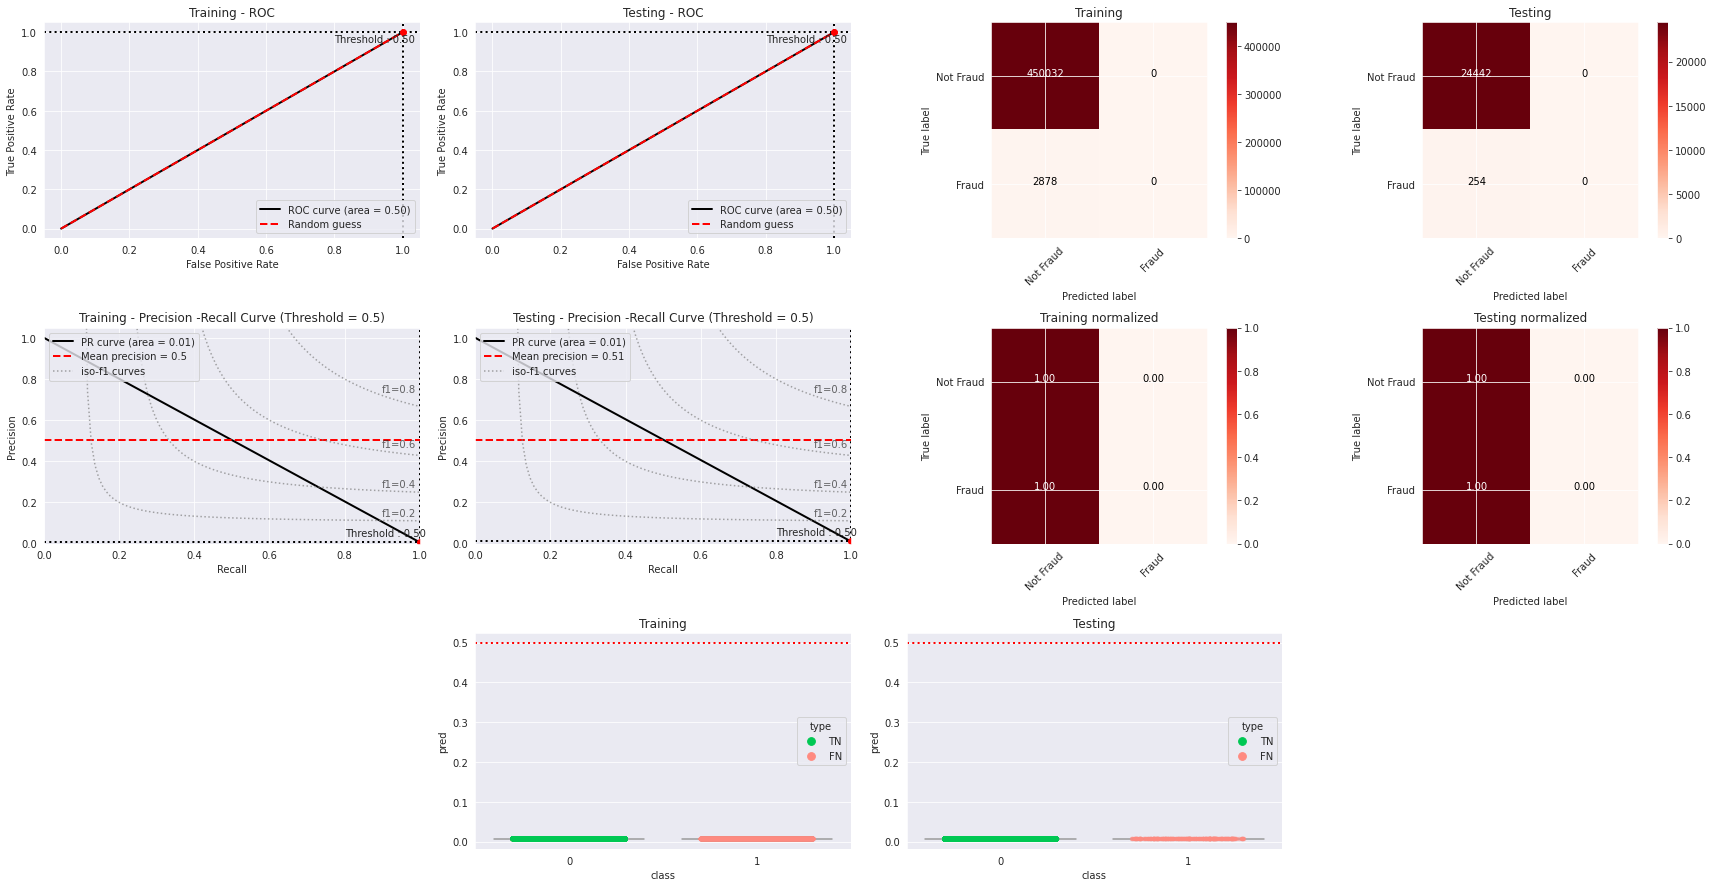

In [ ]:
evaluation_plot(dummy_model,X_train,X_test,y_train,y_test)

In [ ]:
log_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1130422d50>),
                                                 ('targetencoder',
                                                  TargetEncoder(smoothing=50.0),
                                                  ['job', 'merchant',
                                                   'cc_num'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

train - balanced acc : 0.5054499583666391 , precision : 0.006750743726003712 , recall: 0.18450312717164696, f1: 0.013024921507064365
test - balanced acc : 0.4953433067000329 , precision : 0.009729473184622686 , recall: 0.16141732283464566, f1: 0.018352730528200537


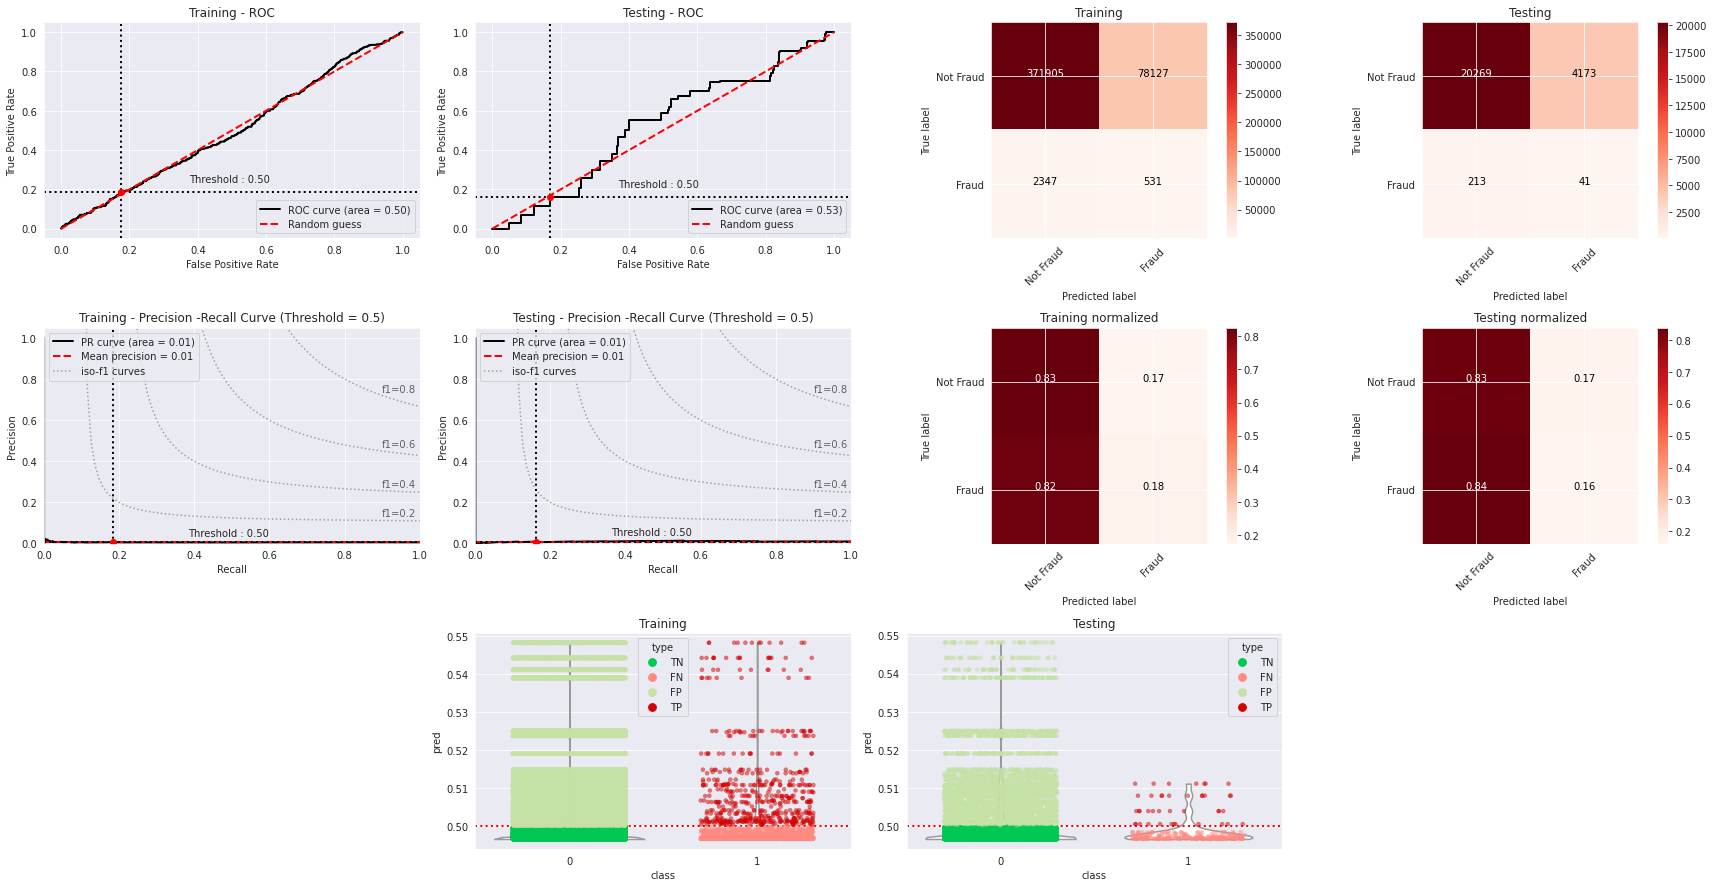

In [ ]:
evaluation_plot(log_model,X_train,X_test,y_train,y_test)

In [ ]:
xgboost_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1148298310>),
                                                 ('targetencoder',
                                                  TargetEncoder(smoothing=50.0),
                                                  ['job', 'merchant',
                                                   'cc_num'])])),
                ('xgbclassifier', XGBClassifier())])

train - balanced acc : 0.8623981920902642 , precision : 0.927967985771454 , recall: 0.7251563585823488, f1: 0.8141213185098498
test - balanced acc : 0.5687135284752527 , precision : 0.7954545454545454 , recall: 0.1377952755905512, f1: 0.23489932885906042


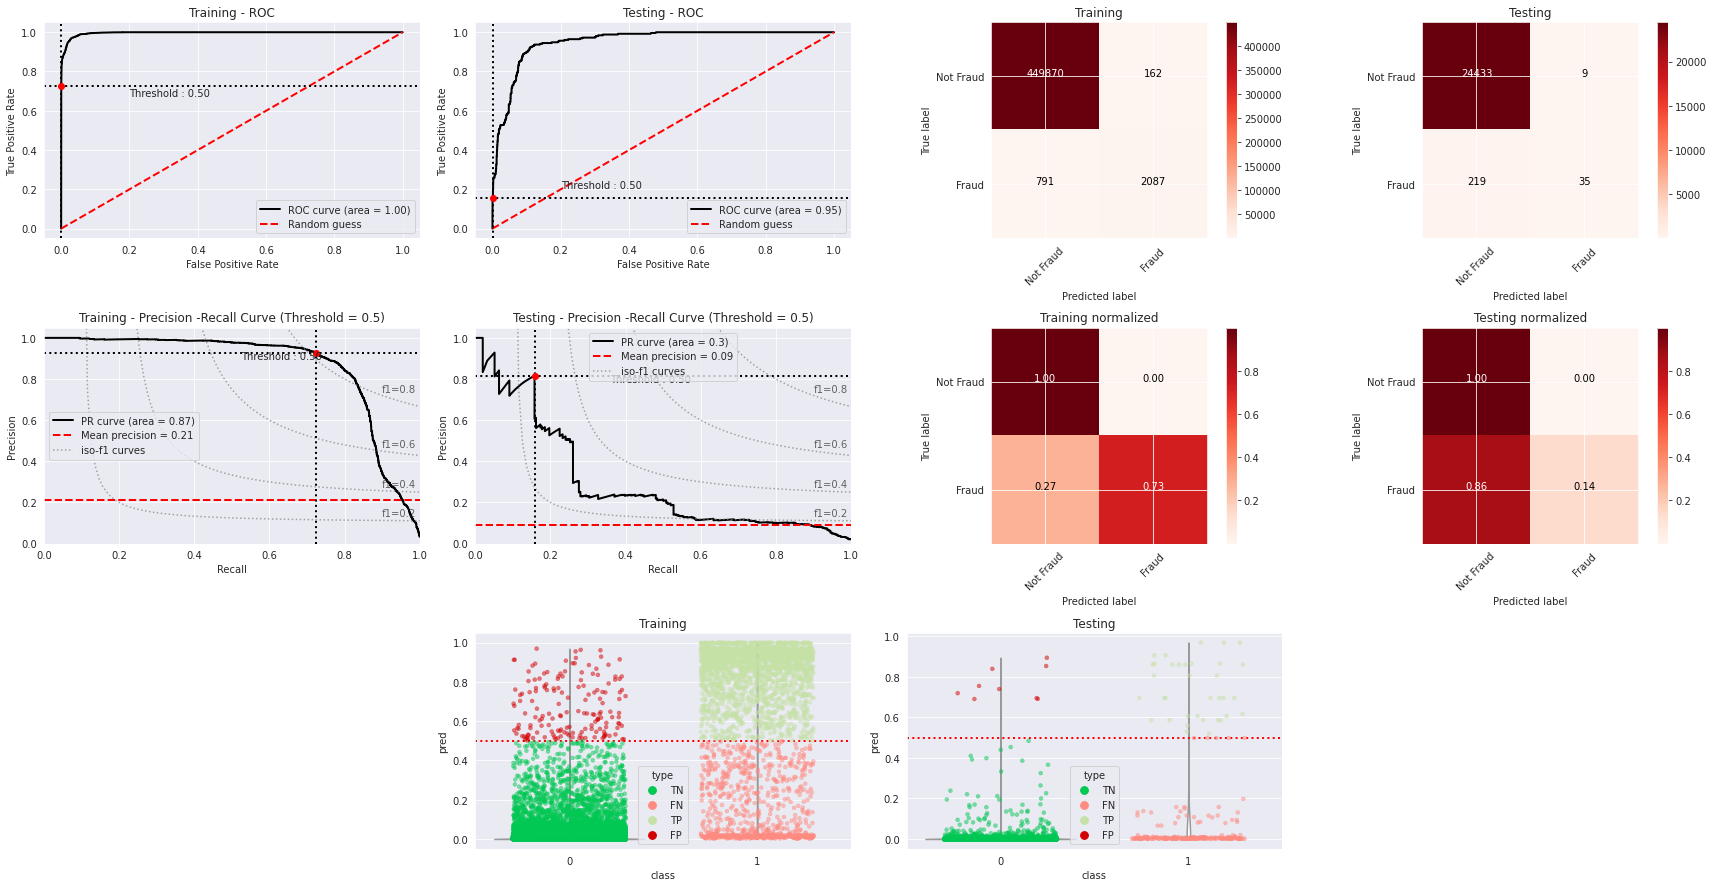

Without any sampling techniques deployed. XGBoost was able to produce far better results than both the other 2 models - the other 2 models was no better than a coin flip.

### Error Analysis

In [ ]:
train_proba = xgboost_model.predict_proba(X_train)
train_prob = xgboost_model.predict(X_train)

In [ ]:
df_ea = pd.DataFrame({'proba':train_proba[::,1],
                      'predictions':train_prob,
                      'actual':y_train})

Text(0, 0.5, 'False Positive')

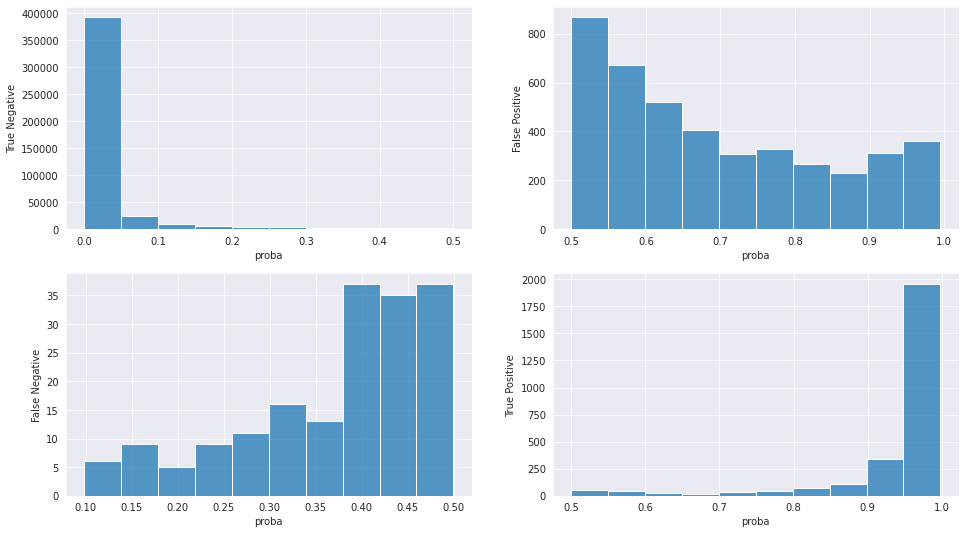

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (16,9))

data = df_ea.loc[(df_ea['predictions']==0)&
                 (df_ea['predictions']==df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins =10 , ax = ax[0,0])
ax[0,0].set_ylabel('True Negative')

data = df_ea.loc[(df_ea['predictions']==1)&
                 (df_ea['predictions']==df_ea['actual'])].sort_values(by = 'proba')

sns.histplot(data = data , x = 'proba', bins =10 , ax = ax[1,1])
ax[1,1].set_ylabel('True Positive')

data = df_ea.loc[(df_ea['predictions']==0)&
                 (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins=10, ax = ax[1,0])
ax[1,0].set_ylabel('False Negative')

data = df_ea.loc[(df_ea['predictions']==1)&
                 (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins=10, ax = ax[0,1]);
ax[0,1].set_ylabel('False Positive')

1. The model seems to be fairly confident with it's prediction for non-fraudulent cases, where the predicted probability largely is below 5%.
2. A major proportion of the false positive cases are on the borderline - near the 50% threshold.
3. A majority of the false negative prediction made by the model are close to proba = 0

In [ ]:
fn_exp =\
df_train.iloc[df_ea.loc[(df_ea['predictions']==0)&
                        (df_ea['proba']<0.05)&
                        (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' ).index][features]

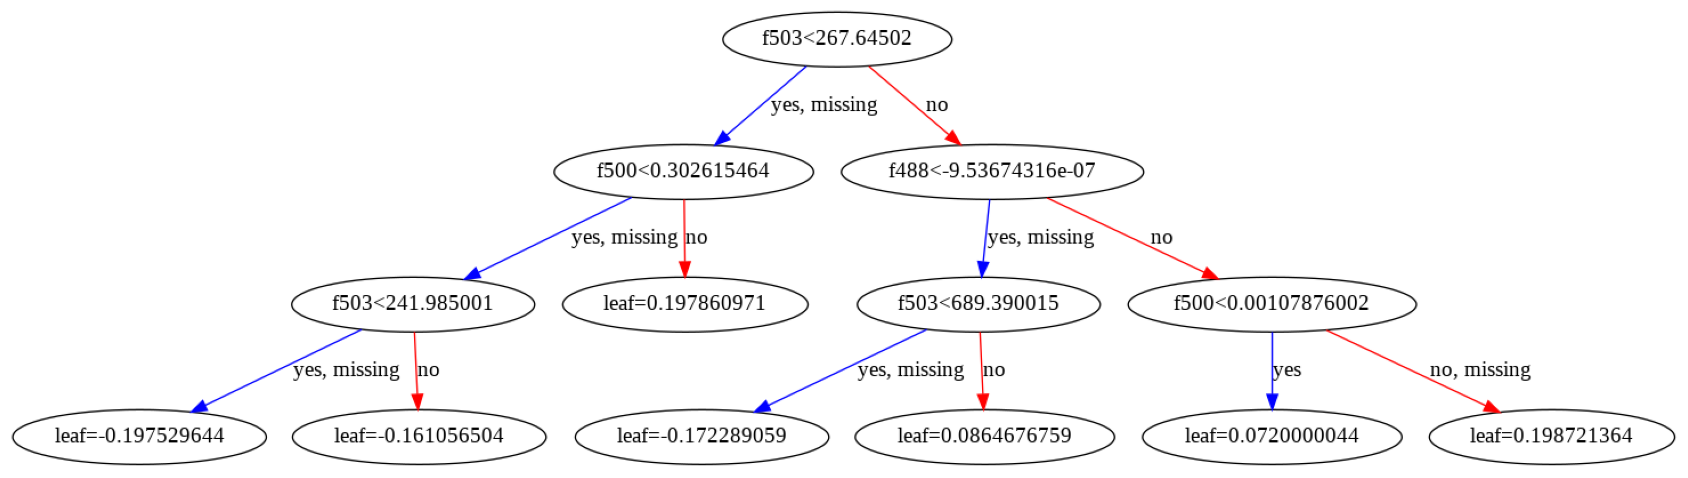

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgboost_model.steps[1][1] , ax = ax)

Most of the decision tree is dependent on F498 (Job) and F502(amt)

In [ ]:
Feature_importance = pd.DataFrame({'feature':xgboost_model.steps[0][1].get_feature_names(),
                                   'importance':xgboost_model.steps[1][1].feature_importances_}).sort_values(by = 'importance', ascending = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


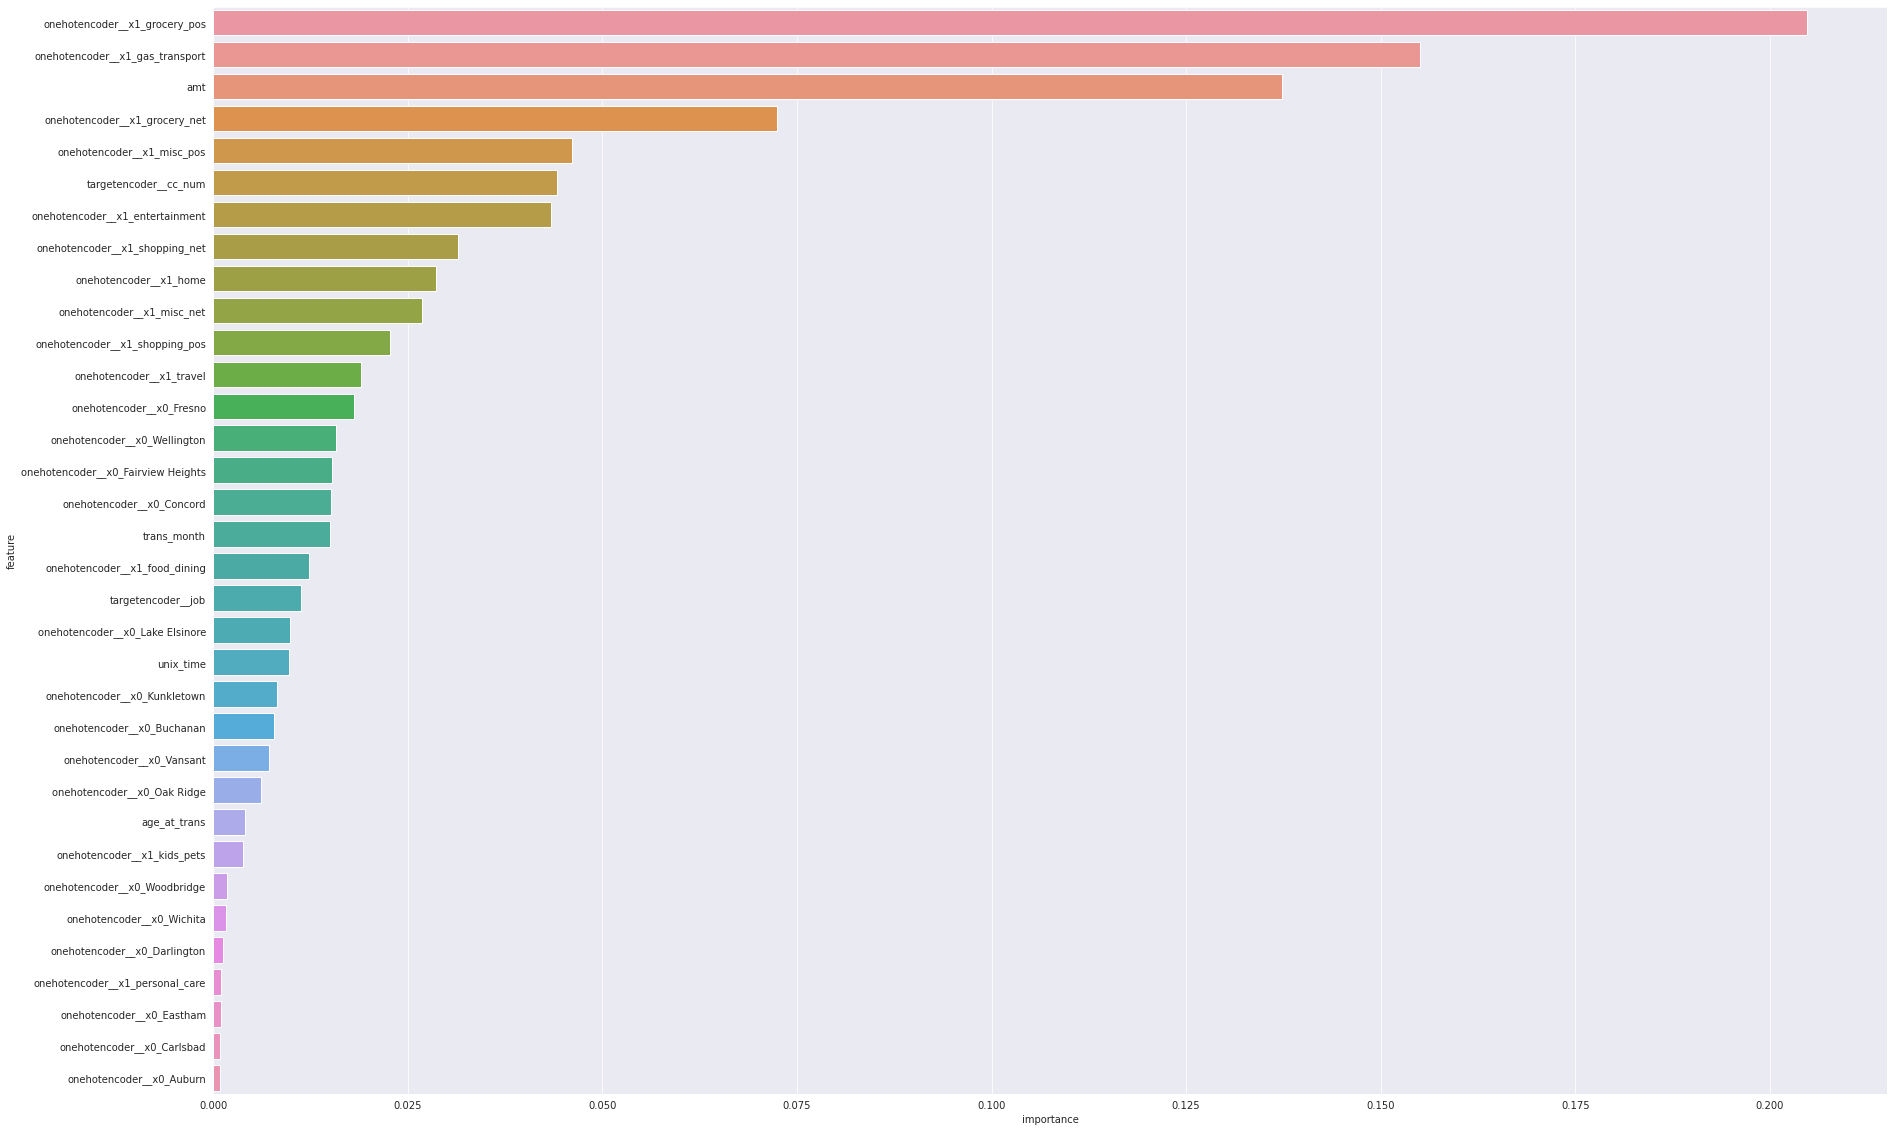

In [ ]:
fig,ax = plt.subplots(figsize = (30,20))
mask = Feature_importance['importance']>0
sns.barplot(data = Feature_importance[mask] , x = 'importance' , y ='feature', orient ='h' , ax = ax)

In [ ]:
fn_exp.value_counts()

city            city_pop  job                              unix_time   category        amt    merchant                     trans_year  trans_month  age_at_trans
Youngstown      163222    Primary school teacher           1347233909  misc_pos        8.14   fraud_Dickinson Ltd          2012        9            89.0            1
Deer River      5137      Automotive engineer              1340145888  kids_pets       20.29  fraud_Barton LLC             2012        6            45.0            1
                                                           1340230564  kids_pets       16.76  fraud_Gleason and Sons       2012        6            45.0            1
                                                           1340232327  kids_pets       19.37  fraud_Metz, Russel and Metz  2012        6            45.0            1
                                                           1340236605  travel          11.07  fraud_Hackett Group          2012        6            45.0            1
         

In [ ]:
fn_exp

,city,city_pop,job,unix_time,category,amt,merchant,trans_year,trans_month,age_at_trans
361799,Wellington,2645,Corporate investment banker,1386199712,kids_pets,25.15,fraud_Bogisich-Weimann,2013,12,29.0
125111,Craigsville,3690,Product designer,1333201672,food_dining,95.59,"fraud_Konopelski, Schneider and Hartmann",2012,3,45.0
424467,Bath,10818,"Lecturer, further education",1342655968,kids_pets,24.44,fraud_Pacocha-Weissnat,2012,7,42.0
175538,Columbus,783285,"Psychologist, counselling",1379630160,food_dining,92.01,fraud_Connelly PLC,2013,9,37.0
337845,Eastham,4937,Food technologist,1381096967,food_dining,98.85,fraud_Kuphal-Toy,2013,10,73.0
...,...,...,...,...,...,...,...,...,...,...
348388,Grand Rapids,375580,Historic buildings inspector/conservation officer,1370066871,misc_pos,8.47,fraud_Towne LLC,2013,6,37.0
405938,Bulverde,9838,Chief Financial Officer,1339346451,kids_pets,17.36,fraud_Schoen-Quigley,2012,6,50.0
318038,Mineral Bluff,4333,Pension scheme manager,1358899017,misc_pos,7.30,"fraud_Yost, Block and Koepp",2013,1,57.0
378038,Ambler,32412,Licensed conveyancer,1366260070,misc_pos,9.03,fraud_Simonis-Prohaska,2013,4,29.0


In [ ]:
ctf.fit(X_train,y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9ab346b4d0>),
                                ('targetencoder', TargetEncoder(smoothing=50.0),
                                 ['job', 'merchant'])])

In [ ]:
test = ctf.transform(fn_exp)

In [ ]:
pd.DataFrame.sparse.from_spmatrix(data = test, columns =xgboost_model.steps[0][1].get_feature_names() )

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,onehotencoder__x0_Abita Springs,onehotencoder__x0_Adams,onehotencoder__x0_Adamsville,onehotencoder__x0_Adel,onehotencoder__x0_Akron,onehotencoder__x0_Alabaster,onehotencoder__x0_Albany,onehotencoder__x0_Albertson,onehotencoder__x0_Allentown,onehotencoder__x0_Ambler,onehotencoder__x0_Amboy,onehotencoder__x0_Anchorage,onehotencoder__x0_Angier,onehotencoder__x0_Angleton,onehotencoder__x0_Anniston,onehotencoder__x0_Appleton,onehotencoder__x0_Arcadia,onehotencoder__x0_Argyle,onehotencoder__x0_Aromas,onehotencoder__x0_Asheville,onehotencoder__x0_Ashland,onehotencoder__x0_Athens,onehotencoder__x0_Atlanta,onehotencoder__x0_Auburn,onehotencoder__x0_Austin,onehotencoder__x0_Avilla,onehotencoder__x0_Avon,onehotencoder__x0_Avondale,onehotencoder__x0_Ayden,onehotencoder__x0_Bailey,onehotencoder__x0_Bald Knob,onehotencoder__x0_Ballwin,onehotencoder__x0_Baltimore,onehotencoder__x0_Bassett,onehotencoder__x0_Bath,onehotencoder__x0_Bayville,onehotencoder__x0_Beacon Falls,onehotencoder__x0_Bear Creek,onehotencoder__x0_Bellevue,onehotencoder__x0_Bellingham,...,onehotencoder__x0_Westfield,onehotencoder__x0_Westport,onehotencoder__x0_White,onehotencoder__x0_White Plains,onehotencoder__x0_Whitefield,onehotencoder__x0_Whitmore Lake,onehotencoder__x0_Wichita,onehotencoder__x0_Williamsburg,onehotencoder__x0_Winchester,onehotencoder__x0_Winder,onehotencoder__x0_Winnemucca,onehotencoder__x0_Winnetka,onehotencoder__x0_Woodbridge,onehotencoder__x0_Yerington,onehotencoder__x0_Yonkers,onehotencoder__x0_Yorba Linda,onehotencoder__x0_Yorktown,onehotencoder__x0_Youngstown,onehotencoder__x1_entertainment,onehotencoder__x1_food_dining,onehotencoder__x1_gas_transport,onehotencoder__x1_grocery_net,onehotencoder__x1_grocery_pos,onehotencoder__x1_health_fitness,onehotencoder__x1_home,onehotencoder__x1_kids_pets,onehotencoder__x1_misc_net,onehotencoder__x1_misc_pos,onehotencoder__x1_personal_care,onehotencoder__x1_shopping_net,onehotencoder__x1_shopping_pos,onehotencoder__x1_travel,targetencoder__job,targetencoder__merchant,city_pop,unix_time,amt,trans_year,trans_month,age_at_trans
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004963,0.00577,2645.0,1.386200e+09,25.15,2013.0,12.0,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003021,0.00577,3690.0,1.333202e+09,95.59,2012.0,3.0,45.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009989,0.00577,10818.0,1.342656e+09,24.44,2012.0,7.0,42.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004322,0.00577,783285.0,1.379630e+09,92.01,2013.0,9.0,37.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004364,0.00577,4937.0,1.381097e+09,98.85,2013.0,10.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,